# Modelisation of a radiative condenser using water as a refrigerant

Description - Motivation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize

import CoolProp.CoolProp as CP

## PDRC study

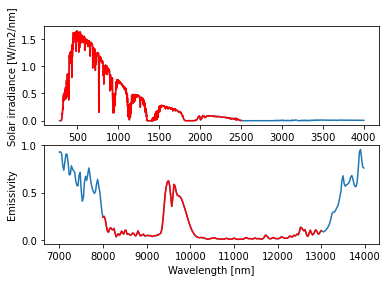

In [3]:
#Constant
hPlank = 6.62e-34 #J.s
c = 3e8 #m/s
kb = 1.38e-23 #J/K
Tamb = 20+273.15 #K
em = 0.98 #emittance
R = 0.98 #reflectance
hair = 10 #W/m2/K (convective flux)

#Importation of atmospheric data
df = pd.read_excel(r"AtmosphericData.xlsx")
df8_13 = df[df['WaveL']>=8][df[df['WaveL']>=8]['WaveL']<=13] #select the values between 8 and 13 microns
waveL = np.array([lamb*1e3 for lamb in df8_13['WaveL']]) #nm
EmAtm = np.array([em for em in df8_13['Em']])

#Importation of solar data
df2 = pd.read_excel(r'SolarData.xlsx')
df2.head()
df300_2500 = df2[df2['WaveL']>=300][df2[df2['WaveL']>=300]['WaveL']<=2500] #select the values between 0.3 and 2.5 microns
waveLsun = np.array([lamb for lamb in df300_2500['WaveL']]) #nm
Isun = np.array([I for I in df300_2500['GlobalTilt']]) #W/m2/nm

#Plot
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df2['WaveL'],df2['GlobalTilt'])
ax1.plot(waveLsun,Isun,'red')
ax1.set_ylabel('Solar irradiance [W/m2/nm]')

ax2.plot(df['WaveL']*1e3,df['Em'])
ax2.plot(waveL,EmAtm,'red')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Emissivity');

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests
$\dot{Q}_{net}(T_w) = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$

with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

In [4]:
def Ibb(T,lamb,h=hPlank,c=c,kb=kb): #W/m/nm
    # lamb is in m
    return (2*hPlank*c**2/(lamb**5*(np.exp(hPlank*c/(kb*lamb*T))-1)))*1e-9

def Q_PDRC(Tc,hair = hair,Tamb=Tamb): #Tc in K
    Rad = Ibb(Tc,waveL*1e-9)*em-Ibb(Tamb,waveL*1e-9)*EmAtm #W/m2/nm (radiation/atm spectrum within 8-13 microns)
    Intrad = integrate.simpson(Rad,waveL)
    Sun = (1-R)*Isun #W/m2/nm (solar spectrum within 0.3 and 2.5 microns)
    Intsun = integrate.simpson(Sun,waveLsun)
    Nonrad = hair*(Tamb-Tc)
    return np.pi*(Intrad-Intsun) -Nonrad#W/m2

Text(0.5, 1.0, 'Estimation of the flux created by the PDRC in function of the wall temperature')

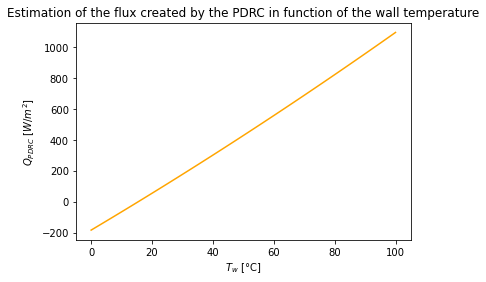

In [5]:
Tc = np.linspace(0,100,100)
y = [Q_PDRC(T+273.15) for T in Tc]
plt.plot(Tc,y,color = 'orange')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$Q_{PDRC} \ [W/m^2]$')
plt.title('Estimation of the flux created by the PDRC in function of the wall temperature')

The result is in accordance to the one in the paper.

### Estimation over the inverse function

Adjustment of the relation between the heat flux and the condenser temperature is made to be able to calculate the inverse function

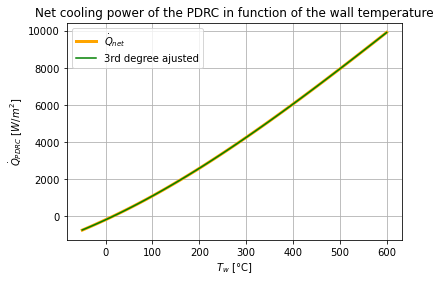

In [52]:
import numpy.polynomial.polynomial as nppol

x = np.linspace(-50,600,100)
y = [Q_PDRC(T+273.15) for T in x]
#ajustement the polynom over a large scale
coeff2 = np.polyfit(x,y,2)
y2 = coeff2[0]*x**2 + coeff2[1]*x + coeff2[2]
coeff3 = np.polyfit(x,y,3)
y3 = coeff3[0]*x**3 + coeff3[1]*x**2 + coeff3[2]*x + coeff3[3]

def Qadjust(x):
    y = coeff3[0]*x**3 + coeff3[1]*x**2 + coeff3[2]*x + coeff3[3]
    return y

def diff(x,a):
    yt = Qadjust(x)
    return (yt - a )**2

def Twc(Q):
    #Inverse function of Q_net
    n = 100
    x = np.arange(Q*(1-0.2), Q*(1+0.2), 2*Q*0.2/n)
    y = np.zeros(x.shape)
    for idx,x_value in enumerate(x):
        res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
        y[idx] = res.x[0]
    return y[int(n/2)]+273.15


#Plot
plt.plot(x,y,'orange', label='$\dot{Q}_{net}$',linewidth = 3)
#plt.plot(x,y2,'red',label = '2nd degree')
plt.plot(x,y3,'green',label = '3rd degree ajusted')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{PDRC} \ [W/m^2]$')
plt.title('Net cooling power of the PDRC in function of the wall temperature')
plt.legend()
plt.grid()
#plt.savefig("PDRC.png",dpi=200)
plt.show()

The calculation of the inverse function takes time so for the test the simple linerisation can be made

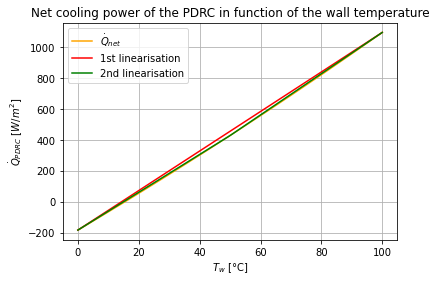

In [7]:
Tc = np.linspace(0,100,100)
y = [Q_PDRC(T+273.15) for T in Tc]
#Linerarisation 1er ordre
a = (np.max(y)-np.min(y))/(np.max(Tc)-np.min(Tc))
b = np.max(y)-a*np.max(Tc)
ylin = a*Tc+b
#linearisation second ordre
a2 = (np.max(y[:50])-np.min(y[:50]))/(np.max(Tc[:50])-np.min(Tc[:50]))
b2 = np.max(y[:50])-a2*np.max(Tc[:50])
a2b = (np.max(y[50:])-np.min(y[50:]))/(np.max(Tc[50:])-np.min(Tc[50:]))
b2b = np.max(y[50:])-a2b*np.max(Tc[50:])
ylin2 = np.concatenate((a2*Tc[:50]+b2,a2b*Tc[50:]+b2b))
# Def inversed function 2nd order
def TwcLin(Q): #K
    if Q<= np.max(y[:50]):
        return (Q-b2)/a2+273.15
    else:
        return (Q-b2b)/a2b+273.15

#Plot
plt.plot(Tc,y,'orange', label='$\dot{Q}_{net}$')
plt.plot(Tc,ylin,'red',label = '1st linearisation')
plt.plot(Tc,ylin2,'green',label = '2nd linearisation')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{PDRC} \ [W/m^2]$')
plt.title('Net cooling power of the PDRC in function of the wall temperature')
plt.legend()
plt.grid()
#plt.savefig("PDRC.png",dpi=200)
plt.show()

## Modelisation of the system

###  First model (en cours)

In this model, we consider the following geometry: a one channel tube discretized in mesh where the gaz goes one way and liquid can accumulate in the tube (or not if the inclinaison is enough: this will be taken into in the angle and the void rate).

In [43]:
#Fluid parameters
mwater = 3.5/10 #kg/s
Tin = 65+273.15 #K
Pin = CP.PropsSI('P','T',Tin,'Q',1,'water');print(f'P_in = {Pin} Pa') #Pa
Hin= CP.PropsSI('H','P',Pin,'Q',1,'water')
#Hin= CP.PropsSI('H','P',Pin,'T',Tin,'water')
Tamb = 20+273.15 #K

#Geometry
Lmax = 4 #m (length of the tube)
ni = 6000 #number of mesh
dx = Lmax/ni;print(f'dx ={dx*1e3} mm') #m (elementary length)
et = 30e-2 #m (tube height)
w = 0.5 #m #tube width
e = 1.1e-3 #m (tube thickness)
theta = np.pi/10 #rad (angle d'inclinaison)
condt = 239 #W/m/K (thermal conductivity of the material: aluminium)
G = mwater/(w*et) #m/s (water speed)
Dh = 4*w*et/(2*(w+et)); #m (hydraulic diameter)
K=0.4
Rein = G*Dh*CP.PropsSI('D','T',Tin,'Q',1,'water')/CP.PropsSI('V','T',Tin,'Q',1,'water');print(f'entry Re = {Rein}') #Rel = min(Rel,Reg)
print(f'L/Dh = {Lmax/Dh}')
#Constant
sig = 5.67e-8 #W/m2/K4

P_in = 25041.598084684127 Pa
dx =0.6666666666666666 mm
entry Re = 12815.672836350775
L/Dh = 10.666666666666668


In [44]:
#Gives the Reynold for either liquid or gas phase at saturation or Re_l in general
def Reyn(v,L,p,H=None,ph=2): 
    if ph==0: #liquid
        return v*L*CP.PropsSI('D','P',p,'Q',0,'water')/CP.PropsSI('V','P',p,'Q',0,'water')
    if ph==1: #gas
        return v*L*CP.PropsSI('D','P',p,'Q',1,'water')/CP.PropsSI('V','P',p,'Q',1,'water')
    return v*L*CP.PropsSI('D','P',p,'H',H,'water')/CP.PropsSI('V','P',p,'H',H,'water')

#zeta Muller
def zeta(Re): 
    if Re < 1187:
        return 64/Re
    return 0.3164/Re**(1/4)
    print(2)

#Void rate
def alpha(x,ro_gaz,ro_l): 
    gamm = K+(1-K)*((ro_l/ro_gaz+K*(1-x)/max(1e-7,x))/(1+K*(1-x)/max(1e-7,x)))**0.5
    return 1/(1+(1-x)/max(1e-7,x)*ro_gaz/ro_l*gamm)

#Vapor exchange coefficient
def h_vapor(P,H,x,G,Dh):
    NuL = 0.023*Reyn(G,Dh,P,ph=0)**0.8*CP.PropsSI('Prandtl','P',P,'Q',0,'water')**0.3; #Nussel liquid
    if x>=1 or x<=1e-7:    #If monophasic
        Numono = 0.023*Reyn(G,Dh,P,H=H)**0.8*CP.PropsSI('Prandtl','P',P,'H',H,'water')**0.3
        h = CP.PropsSI('L','P',P,'H',H,'water')/Dh*Numono
    else:
        Pred = P/CP.PropsSI('Pcrit','water') #reduced pressure
        NuShah = NuL*((1-x)**0.8+3.8*x**0.76*(1-x)**0.04/Pred**0.38)                                                  
        h = CP.PropsSI('L','P',P,'H',H,'water')/Dh*NuShah
        #h = CP.PropsSI('L','Q',0,'P',P,'water')/Dh*NuShah #Leviathan
    return h

#Model
def Model(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,
          Lmax=Lmax,et=et,w=w,dx=dx):
    #Init
    P,H,T,Tw,dPG,dPdyn,dPfr,hv,hnet,x,AL,Flux = [Pin],[Hin],[Tin],[Tin],[0],[0],[0],[],[],[1],[1],[]
    G ,Dh = mwater/(w*et), 4*w*et/(2*(w+et))
    for i in range(1,ni): # loop for each mesh
        #internal exchange coefficient calculation
        h = h_vapor(P[-1],H[-1],x[-1],G,Dh)
        hv.append(h)
        #external radiative exchange coefficient
        hnet.append(Q_PDRC(Tw[-1])/(Tw[-1]-Tamb)/(2*dx*(w+et)))
        #hnet = [3000]
        #Calculation of the flux
        Q = 1/(e/condt/(dx*2*(w+et))+1/h/(dx*2*(w+et))+1/hnet[-1]/(2*dx*(w+et)))*(T[-1]-Tamb)
        Flux.append(Q)
        #Deduce the delta enthalpy
        dH = Q/mwater
        H.append(H[-1]-dH)
        #Deduce the vapour title
        x.append(max(min(1,CP.PropsSI('Q','P',P[-1],'H',H[-1],'water')),0)) #must stay between 0 and 1
        #Deduce Temperatures
        T.append(CP.PropsSI('T','P',P[-1],'H',H[-1],'water'))
        Tw.append(TwcLin(Q))
        #Tw.append(Twc(Q))
        #Pressure losses du to friction
        ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water'))
        #ro_gaz = CP.PropsSI('D','H',H[-1],'P',P[-1],'water')
        ro_liq = CP.PropsSI('D','P',P[-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,P[-1],ph=0))*mwater**2/2/ro_liq/Dh
        #A = zeta(Reyn(G,Dh,P[-1],ph=0))*G**2/2/ro_liq/Dh #Leviathan
        B = zeta(Reyn(G,Dh,P[-1],H=H[-1]))*mwater**2/2/ro_gaz/Dh 
        #B = zeta(Reyn(G,Dh,P[-1],ph=1))*G**2/2/ro_gaz/Dh #Leviathan
        Ge = A+2*(B-A)*x[-1]
        dP = dx*(Ge*(1-x[-1])**(1/3)+B*x[-1]**3)
        #Dynamical pressure losses
            #downstream cell
        AL.append(alpha(x[-1],ro_gaz,ro_liq))
        Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1]) + G**2*(1-x[-1])**2/ro_liq/(1-min((1-1e-7),AL[-1])) #max(1e-7,AL[-1])
        #Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1])+G**2*(1-x[-1])**2/ro_liq/max(1e-7,AL[-1]) #Leviathan
            #upstream cell
        indice = max(i-1,0) #at the begening P does not have 2 elements
        ro_gaz0 = min(CP.PropsSI('D','P',P[indice],'Q',1,'water'),CP.PropsSI('D','H',H[-2],'P',P[indice],'water'))
        #ro_gaz0 = CP.PropsSI('D','H',H[-2],'P',P[indice],'water')
        Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/(1-min((1-1e-7),AL[-2]))
        #Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/max(1-1e-7,AL[-2]) #Leviathan
        #Gravitational pressure losses
        dPg = dx*((1-AL[-1])*ro_liq+AL[-1]*ro_gaz)*9.81*np.sin(theta)
        dPG.append(dPg)
        dPdyn.append(Pdyn1-Pdyn0) #;print(Pdyn0-Pdyn1)
        dPfr.append(dP) #;print(dP)
        P.append(P[-1]-(dPfr[-1]+dPG[-1]-dPdyn[-1]))
    return T,Tw,P,x,AL,hv,hnet,dPfr,dPdyn,dPG, Flux

In [45]:
T,Tw,P,x,AL,hv,hnet,dPfr,dPdyn,dPG, Q = Model()

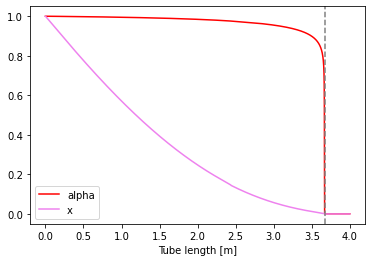

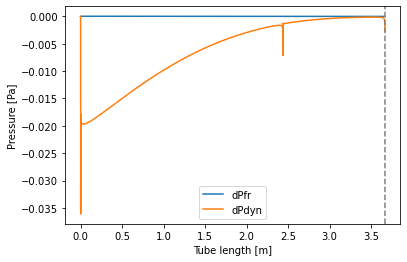

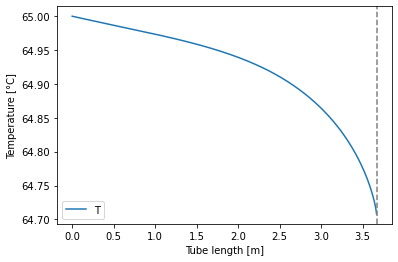

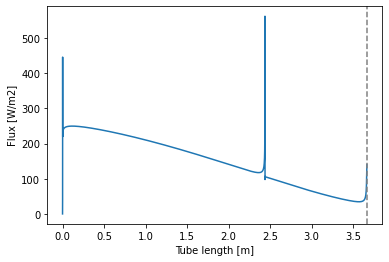

In [47]:
#Plot
Len = np.array(range(0,ni))*dx
plt.plot(Len,AL,'red',label='alpha')
plt.plot(Len,x,'violet',label='x')
plt.xlabel('Tube length [m]')
#Plot the line x == 0
indf = np.where(np.array(x)<1e-7)[0][0]
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()
#plt.savefig("title.png",dpi=200)
plt.show()

plt.plot(Len[:indf],dPfr[:indf],label = 'dPfr')
plt.plot(Len[:indf],dPdyn[:indf],label = 'dPdyn')
#plt.plot(Len[:indf],dPG[:indf], label = 'dPg')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.xlabel('Tube length [m]')
plt.ylabel('Pressure [Pa]')
plt.legend()
#plt.savefig("Pressure.png",dpi=200)
plt.show()

#plt.plot(Len[:indf],(np.array(Tw)-273.15)[:indf],label ='Tw')
plt.plot(Len[:indf],(np.array(T)-273.15)[:indf], label = 'T')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.xlabel('Tube length [m]')
plt.ylabel('Temperature [°C]')
plt.legend()
#plt.savefig("Temperature.png",dpi=200)
plt.show()

plt.plot(Len[:indf],Q[:indf],label='Flux')
plt.xlabel('Tube length [m]')
plt.ylabel('Flux [W/m2]')
#plt.savefig("Flux.png",dpi=200)
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')

**Look at the different component of the flux**

hv = [2.553964517648581,95949.39859721546] W/m2/K


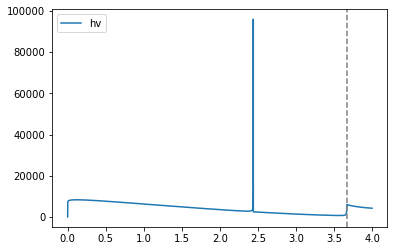

hnet = [-390743358.1467992,14724324.232656853] W/m2/K


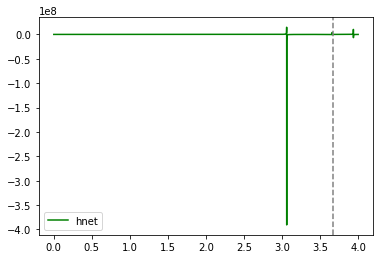

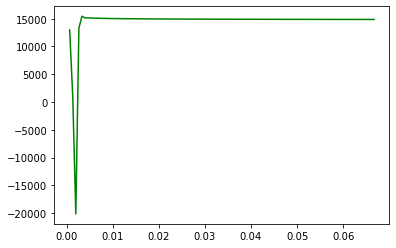

In [48]:
plt.plot(Len[1:],hv,label = 'hv');print(f'hv = [{np.min(hv)},{np.max(hv)}] W/m2/K')
hcond = condt/e*np.ones(ni-1)
#plt.plot(Len[1:],hcond,label = 'hcond');print(f'hcond = {hcond[0]} W/m2/K')
#plt.plot(Len[1:],hnet,label = 'hnet');print(f'hnet = [{np.min(hnet)},{np.max(hnet)}] W/m2/K')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()
#plt.savefig("hv.png",dpi=200)
plt.show()
#Plot only hnet
plt.plot(Len[1:],hnet,'green',label = 'hnet');print(f'hnet = [{np.min(hnet)},{np.max(hnet)}] W/m2/K')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
#plt.savefig("hnet.png",dpi=200)
plt.legend();
#Zoom hnet before x=0
plt.show()
plt.plot(Len[1:101],hnet[:100],'green',label = 'hnet')
#This evolution is the same for Tw at the begining